In [1]:
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import ToTensor
from datasets import load_dataset
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
from tqdm import tqdm
from collections import Counter
import random
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Dataset Loading

In [3]:
dataset = load_dataset("tatoeba", lang1="ar", lang2="en")

README.md:   0%|          | 0.00/8.93k [00:00<?, ?B/s]

tatoeba.py:   0%|          | 0.00/4.41k [00:00<?, ?B/s]

The repository for tatoeba contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tatoeba.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
dataset.keys()

dict_keys(['train'])

In [5]:
dataset.shape

{'train': (27905, 2)}

## Spliting dataset

In [6]:
train_valtest=dataset['train'].train_test_split(test_size=0.2,seed=42)
val_test=train_valtest['test'].train_test_split(test_size=0.5,seed=42)
train_data=train_valtest['train']
val_data=val_test['train']
test_data=val_test['test']

In [7]:
print(f'train_data: {train_data.shape}')
print(f'val_data: {val_data.shape}')
print(f'test_data: {test_data.shape}')

train_data: (22324, 2)
val_data: (2790, 2)
test_data: (2791, 2)


In [8]:
print(train_data['translation'][0]['ar'])

هل ترى ما أعني؟


## Text Preprocessing & Tokenization

In [9]:
def preprocess_arabic_text(text):
  # Remove diacritics
  arabic_diacritics = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
  text = re.sub(arabic_diacritics, '', text)
  # Remove Tatweel (Kashida)
  text = re.sub(r'ـ+', '', text)
    # Normalize letters
  replacements = {
        'أ': 'ا',
        'إ': 'ا',
        'آ': 'ا',
        'ى': 'ي',
        'ؤ': 'ء',
        'ئ': 'ء',
        'ة': 'ه',
        'گ': 'ك',
    }
  for src, target in replacements.items():
      text = text.replace(src, target)

  text=re.sub(r'[^\w\s]','',text)
  text=re.sub(r'\s+',' ',text).strip()
  tokens=word_tokenize(text)
  return tokens


def preprocess_english_text(text):
  text=text.lower()
  text=re.sub(r'[^\w\s]','',text)
  text=re.sub(r'\s+',' ',text).strip()
  tokens=word_tokenize(text)
  return tokens


In [10]:
train_input=[]
train_target=[]
for sample in tqdm(train_data['translation']):
  train_input.append(preprocess_arabic_text(sample['ar']))
  train_target.append(preprocess_english_text(sample['en']))


val_input=[]
val_target=[]
for sample in tqdm(val_data['translation']):
  val_input.append(preprocess_arabic_text(sample['ar']))
  val_target.append(preprocess_english_text(sample['en']))

test_input=[]
test_target=[]
for sample in tqdm(test_data['translation']):
  test_input.append(preprocess_arabic_text(sample['ar']))
  test_target.append(preprocess_english_text(sample['en']))


100%|██████████| 2791/2791 [00:00<00:00, 4605.44it/s]


In [11]:
print(train_input[0])
print(train_target[0])

['هل', 'تري', 'ما', 'اعني']
['do', 'you', 'see', 'what', 'i', 'mean']


## Vocabulary Building

In [12]:
def build_arabic_vocab(input,max_words=10000):
  word_count=Counter()
  for sentence in input:
    word_count.update(sentence)
  most_common = word_count.most_common(max_words-2)
  vocab={word:idx+2 for idx,(word,_) in enumerate(most_common)}
  vocab['<PAD>'] = 0
  vocab['<UNK>'] = 1
  return vocab

In [13]:
def build_english_vocab(input,max_words=10000):
  word_count=Counter()
  for sentence in input:
    word_count.update(sentence)

  most_common = word_count.most_common(max_words-4)
  vocab={word:idx+4 for idx,(word,_) in enumerate(most_common)}
  vocab['<PAD>'] = 0
  vocab['<UNK>'] = 1
  vocab['<BOS>'] = 2
  vocab['<EOS>'] = 3

  return vocab


In [14]:
arabic_vocab=build_arabic_vocab(train_input)
english_vocab=build_english_vocab(train_target)
print(len(arabic_vocab))
print(len(english_vocab))

10000
8366


## Data Encoding

In [15]:
def plot_distribution(data):
  lengths = [len(sentence) for sentence in data]
  max_length = max(lengths)
  mean_length = np.mean(lengths)
  median_length = np.median(lengths)
  p95_length = np.percentile(lengths, 95)

  print(f"Maximum sentence length: {max_length}")
  print(f"Mean sentence length: {mean_length:.2f}")
  print(f"Median sentence length: {median_length}")
  print(f"95th percentile length: {p95_length}")

  plt.figure(figsize=(10, 6))
  plt.hist(lengths, bins=50)
  plt.axvline(x=max_length, color='r', linestyle='--', label=f'Max: {max_length}')
  plt.axvline(x=p95_length, color='g', linestyle='--', label=f'95th: {p95_length:.0f}')
  plt.axvline(x=median_length, color='b', linestyle='--', label=f'Median: {median_length}')
  plt.title("Distribution of sentence Lengths")
  plt.xlabel("Length (number of tokens)")
  plt.ylabel("Count")
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.show()

  truncated_count= sum(1 for length in lengths if length > p95_length )
  truncated_percentage = (truncated_count / len(lengths)) * 100
  print(f"Number of sentences truncated: {truncated_count}")
  print(f"Percentage of sentences truncated: {truncated_percentage:.2f}%")
  return p95_length


Maximum sentence length: 142
Mean sentence length: 5.09
Median sentence length: 4.0
95th percentile length: 10.0


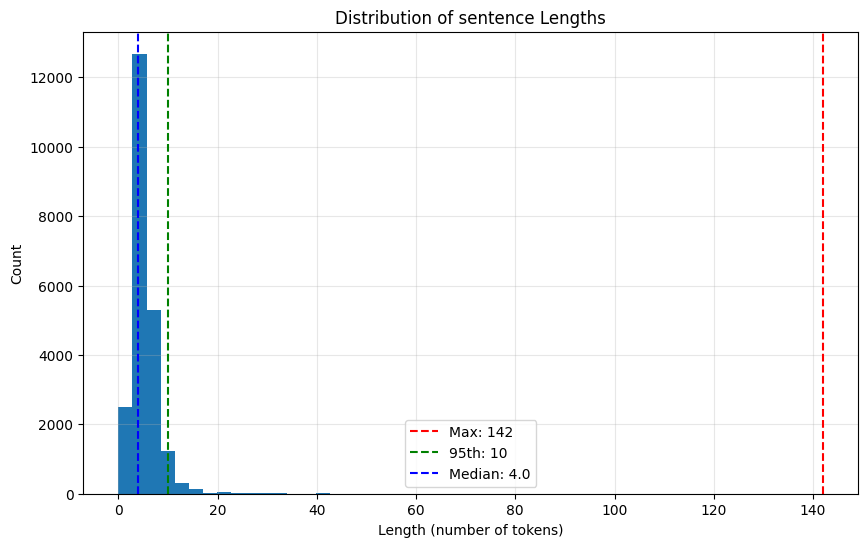

Number of sentences truncated: 844
Percentage of sentences truncated: 3.78%


In [16]:
arabic_length=plot_distribution(train_input)

Maximum sentence length: 205
Mean sentence length: 6.34
Median sentence length: 6.0
95th percentile length: 12.0


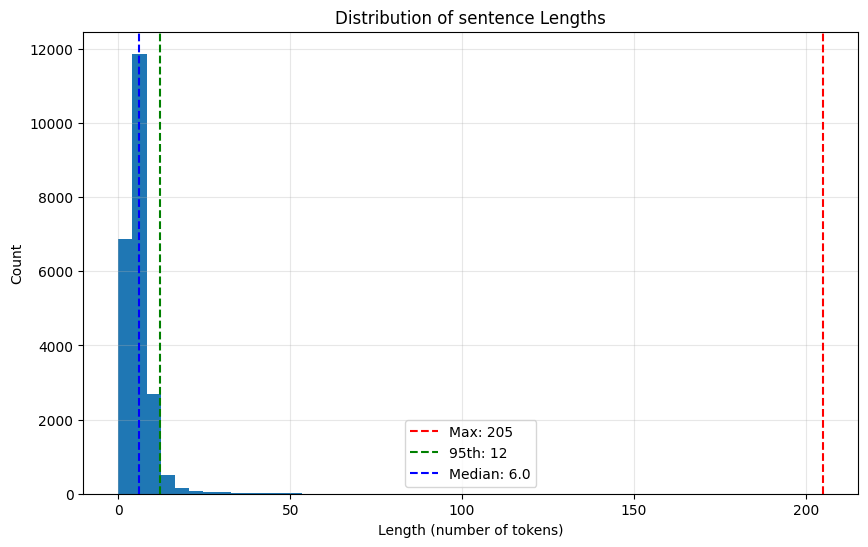

Number of sentences truncated: 889
Percentage of sentences truncated: 3.98%


In [17]:
english_length=plot_distribution(train_target)

In [18]:
def encode_arabic_sentence(sentence,vocab,max_length):
  max_length=int(max_length)
  encoded_sentence=[]
  for word in sentence:
    if word in vocab:
      encoded_sentence.append(vocab[word])
    else:
      encoded_sentence.append(vocab['<UNK>'])
  encoded_sentence=encoded_sentence[:max_length]
  if len(encoded_sentence)<max_length:
    encoded_sentence.extend([vocab['<PAD>']]*int(max_length-len(encoded_sentence)))
  return encoded_sentence

In [19]:
def encode_english_sentence(sentence,vocab,max_length):
  max_length=int(max_length)+2
  encoded_sentence=[vocab['<BOS>']]
  for word in sentence:
    if word in vocab:
      encoded_sentence.append(vocab[word])
    else:
      encoded_sentence.append(vocab['<UNK>'])
  encoded_sentence.append(vocab['<EOS>'])
  encoded_sentence=encoded_sentence[:max_length]
  if len(encoded_sentence)<max_length:
    encoded_sentence.extend([vocab['<PAD>']]*int(max_length-len(encoded_sentence)))
  return encoded_sentence

In [20]:
train_input_encoded=[encode_arabic_sentence(sentence,arabic_vocab,arabic_length) for sentence in train_input]
train_target_encoded=[encode_english_sentence(sentence,english_vocab,english_length) for sentence in train_target]

val_input_encoded=[encode_arabic_sentence(sentence,arabic_vocab,arabic_length) for sentence in val_input]
val_target_encoded=[encode_english_sentence(sentence,english_vocab,english_length) for sentence in val_target]

test_input_encoded=[encode_arabic_sentence(sentence,arabic_vocab,arabic_length) for sentence in test_input]
test_target_encoded=[encode_english_sentence(sentence,english_vocab,english_length) for sentence in test_target]

In [21]:
# convert to tensors
train_input_tensor=torch.tensor(train_input_encoded,dtype=torch.long)
train_target_tensor=torch.tensor(train_target_encoded,dtype=torch.long)

val_input_tensor=torch.tensor(val_input_encoded,dtype=torch.long)
val_target_tensor=torch.tensor(val_target_encoded,dtype=torch.long)

test_input_tensor=torch.tensor(test_input_encoded,dtype=torch.long)
test_target_tensor=torch.tensor(test_target_encoded,dtype=torch.long)

In [22]:
print(train_input_tensor.shape)
print(train_target_tensor.shape)
print(train_input_tensor[0])
print(train_target_tensor[0])

torch.Size([22324, 10])
torch.Size([22324, 14])
tensor([  13,  806,   14, 8455,    0,    0,    0,    0,    0,    0])
tensor([  2,  24,   7,  96,  31,   6, 491,   3,   0,   0,   0,   0,   0,   0])


## DataLoader Preparation

In [23]:
class translationDataset(Dataset):
  def __init__(self,input,target):
    self.input=input
    self.target=target
  def __len__(self):
    return len(self.input)
  def __getitem__(self, index):
      return self.input[index], self.target[index]

In [24]:
train_dataset=translationDataset(train_input_tensor,train_target_tensor)
val_dataset=translationDataset(val_input_tensor,val_target_tensor)
test_dataset=translationDataset(test_input_tensor,test_target_tensor)

train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=16,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=16,shuffle=False)


In [25]:
batch_input,batch_target=next(iter(train_loader))
print(batch_input.shape)
print(batch_target.shape)
print(batch_input[0:3])
print(batch_target[0:3])

torch.Size([16, 10])
torch.Size([16, 14])
tensor([[3360, 1687,    0,    0,    0,    0,    0,    0,    0,    0],
        [   5,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   9,   19, 1235,    0,    0,    0,    0,    0,    0,    0]])
tensor([[   2,    4, 2835,   25,  524,    3,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   2,   75,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0],
        [   2,  401,  281,    3,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0]])


In [26]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

1396
175
175


## network architecture

In [84]:
class Encoder(nn.Module):
  def __init__(self,vocab_size,embedding_dim,hidden_dim,n_layers,dropout):
    super().__init__()
    self.embedding=nn.Embedding(vocab_size,embedding_dim)
    self.lstm=nn.LSTM(embedding_dim,hidden_dim,n_layers,dropout=dropout,batch_first=True)
  def forward(self,x):
    x=self.embedding(x)
    output,(hidden,cell)=self.lstm(x)
    return hidden,cell

In [85]:
class decoder(nn.Module):
  def __init__(self,output_dim,embedding_dim,hidden_dim,n_layers,dropout):
    super().__init__()
    self.output_dim=output_dim
    self.embedding=nn.Embedding(output_dim,embedding_dim)
    self.lstm=nn.LSTM(embedding_dim,hidden_dim,n_layers,dropout=dropout,batch_first=True)
    self.fc=nn.Linear(hidden_dim,output_dim)
  def forward(self,x,hidden,cell):
    x=x.unsqueeze(1)
    x=self.embedding(x)
    output,(hidden,cell)=self.lstm(x,(hidden,cell))
    prediction=self.fc(output.squeeze(1))
    return prediction,hidden,cell


In [86]:
class TranslationModel(nn.Module):
  def __init__(self,encoder,decoder,device):
    super().__init__()
    self.encoder=encoder
    self.decoder=decoder
    self.device=device
  def forward(self,input,target,teacher_forcing_ratio=0.5):
    batch_size=input.shape[0]
    target_len=target.shape[1]
    target_vocab_size=self.decoder.output_dim
    outputs=torch.zeros(batch_size,target_len,target_vocab_size).to(self.device)
    hidden,cell=self.encoder(input)
    x=target[:,0]
    for t in range(1,target_len):
      output,hidden,cell=self.decoder(x,hidden,cell)
      outputs[:,t]=output
      teach_force=random.random()<teacher_forcing_ratio
      top1=output.argmax(1)
      x=target[:,t] if teach_force else top1
    return outputs


In [87]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Training & Evaluation

In [88]:
def train(model,data_loader,optimizer,criterion,device,teach_force=0.5):
  model.train()
  epoch_loss=0
  for batch_input,batch_target in tqdm(data_loader):
    batch_input=batch_input.to(device)
    batch_target=batch_target.to(device)
    optimizer.zero_grad()
    output=model(batch_input,batch_target,teach_force)
    #print("Max index in input batch:", batch_input.max().item())
    #print("Embedding input_dim:", model.encoder.embedding.num_embeddings)
    output_dim=output.shape[-1]
    output=output[:,1:].reshape(-1,output_dim)
    batch_target=batch_target[:,1:].reshape(-1)
    loss=criterion(output,batch_target)
    loss.backward()
    optimizer.step()
    epoch_loss+=loss.item()
  return epoch_loss/len(data_loader)


In [89]:
def evaluate(model,data_loader,criterion,device,input_vocab,target_vocab,reverse_vocab):
  model.eval()
  epoch_loss=0
  all_reference=[]
  all_candidate=[]
  with torch.no_grad():
    for batch_input,batch_target in tqdm(data_loader):
      batch_input=batch_input.to(device)
      batch_target=batch_target.to(device)
      output=model(batch_input,batch_target,0)
      output_dim=output.shape[-1]
      output=output[:,1:]
      batch_target=batch_target[:,1:]
      loss=criterion(output.reshape(-1,output_dim),batch_target.reshape(-1))
      epoch_loss+=loss.item()
      pred_tokens=output.argmax(-1)
      for i in range(batch_target.size(0)):
        reference = [reverse_vocab[token] for token in batch_target[i].tolist() if token != english_vocab['<PAD>']]
        candidate = [reverse_vocab[token] for token in pred_tokens[i].tolist() if token != english_vocab['<PAD>']]
        all_reference.append(reference)
        all_candidate.append(candidate)

  bleu_score=corpus_bleu(all_reference,all_candidate)
  return epoch_loss/len(data_loader),bleu_score

In [90]:
input_dim=len(arabic_vocab)
output_dim=len(english_vocab)
embedding_dim=256
hidden_dim=512
n_layers=2
dropout=0.5
encoder=Encoder(input_dim,embedding_dim,hidden_dim,n_layers,dropout)
decoder=decoder(output_dim,embedding_dim,hidden_dim,n_layers,dropout)
model=TranslationModel(encoder,decoder,device).to(device)
optimizer=torch.optim.Adam(model.parameters())
criterion=nn.CrossEntropyLoss(ignore_index=english_vocab['<PAD>'])


In [91]:
reverse_vocab={idx:word for word,idx in english_vocab.items()}

In [ ]:
num_epoch=10
for epoch in range(num_epoch):
  train_loss=train(model,train_loader,optimizer,criterion,device)
  val_loss,val_score=evaluate(model,val_loader,criterion,device,arabic_vocab,english_vocab,reverse_vocab)
  print(f'Epoch: {epoch+1}/{num_epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, BLEU Score: {val_score:.4f}')



100%|██████████| 175/175 [00:01<00:00, 96.06it/s]


Epoch: 1/10: Train Loss: 5.4232, Val Loss: 5.1151, BLEU Score: 0.0000


100%|██████████| 175/175 [00:01<00:00, 101.85it/s]


Epoch: 2/10: Train Loss: 4.6283, Val Loss: 4.8153, BLEU Score: 0.0000


100%|██████████| 175/175 [00:01<00:00, 101.41it/s]


Epoch: 3/10: Train Loss: 4.1461, Val Loss: 4.6549, BLEU Score: 0.0000


 22%|██▏       | 308/1396 [00:11<00:35, 30.44it/s]

In [ ]:
plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend()
plt.show()

In [ ]:
test_loss,test_score=evaluate(model,test_loader,criterion,device,arabic_vocab,english_vocab,reverse_vocab)
print(f'Test Loss: {test_loss:.4f}, BLEU Score: {test_score:.4f}')